In [2]:
import spacy
import os
import numpy as np
import re
import altair as alt

from collections import defaultdict
from features import feature_pipeline
from utils import read_corpus

import pandas as pd
alt.renderers.enable('mimetype')
from IPython.display import Image
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"

from stanza.server import CoreNLPClient
from treelib import Node, Tree

In [3]:
#text_dir = '/Users/eun-youngchristinapark/MDS-CAPSTONE/capstone_FHIS/corpus/'
#file_list = os.listdir(text_dir)
#corpus = read_corpus(text_dir)
corpus = read_corpus()

## Depth of Sentence 

This feature returns the depth of each sentence using dependency parsing. 
We build a dependency tree using CoreNLP dependency parsing and tree structure from the treelib library.

In [4]:
def dependency_tree(sent):
    '''This function returns the depth of sentence using dependency parsing. 
    Assumptions:
     1. The input 'sent' is CoreNLP_pb2.Sentence data structure.
     2. The dependency parising information in 'sent' (from CoreNLP) is correct. (hence, dependency parsing is out of scope for testing)
     
    Note: If sent has no edges, this function returns an empty tree. Therefore, one word sentence will return an empty tree. 
    Argument: sent (CoreNLP_pb2.Sentence) - sentence for which the dependency tree is built
    Return:   depth of the tree
    '''
    
    tree_list = [Tree()]
    for edge in sent.basicDependencies.edge:
        source = edge.source                                                       # source of the edge
        target = edge.target                                                       # target of the edge
    
        source_tree_idx = -1
        target_tree_idx = -1
        for i, tree in enumerate(tree_list):                                       # find a tree which contains source and call it source_tree
            if tree.get_node(source):                                              # find a tree which contains target and call it target_tree
                source_tree_idx = i
            if tree.get_node(target):
                target_tree_idx = i

        if source_tree_idx < 0 and target_tree_idx < 0:                            # if no source tree, no target tree
            new_tree = Tree()                                                      #     then, create a new tree
            new_tree.create_node(source, source)
            new_tree.create_node(target, target, parent = source)
            tree_list.append(new_tree)
        elif target_tree_idx < 0:                                                  # if source_tree exists and no target_tree,
            tree = tree_list[source_tree_idx]                                      #     add a target node
            tree.create_node(target, target, parent = source)
        elif source_tree_idx < 0:                                                  # if target_tree exists and no source_tree,
            new_tree = Tree()                                                      #     add the source node as the root of the tree 
            new_tree.create_node(source, source)
            sub_tree = tree_list[target_tree_idx]
            new_tree.paste(source, sub_tree)
            tree_list[target_tree_idx] = new_tree
        else:                                                                      # if both source_tree and target_tree exist,
            assert source_tree_idx != target_tree_idx                              #     connect these trees 
            source_tree = tree_list[source_tree_idx]
            target_tree = tree_list[target_tree_idx]
        
            assert target_tree.root == target
            source_tree.paste(source, target_tree)
            tree_list[source_tree_idx] = source_tree
            tree_list[target_tree_idx] = Tree()
        
    tree_depth_list = [tree.depth() for tree in tree_list]                        # get the tree depth for each tree in the list
    

    return max(tree_depth_list), tree_list[np.argmax(tree_depth_list)]            # the tree with max depth is the final tree 

We can take a look at the source and target of each edge in the dependency parsing. Please note that the dependency parsing is from CoreNLP.
We compare this information against the tree generated from dependency_tree function.
We print out the depth of the tree and the tree itself. Note that a tree with one node has depth 0. 

## Testing

We are going to test the function dependency_tree using the test functon test_dependency_tree as shown below.
Given a text, we print out the dependency parse from CoreNLP. We also print out the tree and the depth. 
By comparing the dependency parse from CoreNLP against the displayed tree structure, we can test whether tree is constructed correctly. 

In [5]:
def test_dependency_tree(text, pipeline):
    '''
    This function is to test dependency_tree function.
    Given a text, we print out the dependency parse from CoreNLP. 
    We also print out the tree and the depth. 
    By comparing the dependency parse from CoreNLP against the displayed tree structure, we can test whether tree is constructed correctly. 
    
    Argument: text (str) - a string of text for sentences of which we build dependency parsing tree
              pipeline (feature_pipeline) - feature pipeline class which allows preprocessing of text 
    '''

    #tp = feature_pipeline(text)
    pipeline.preprocess(text)
    text = pipeline.text
    with CoreNLPClient(
        properties = 'es',
        classpath = '/Users/eun-youngchristinapark/Documents/stanza_corenlp/*',
        annotators=['depparse'],
        timeout=30000,
        memory='5G') as client:
        spanish_ann = client.annotate(text)
        
    for sent in spanish_ann.sentence:
        for edge in sent.basicDependencies.edge:
            print(f'source: {edge.source}, target: {edge.target}')
        depth, tree = dependency_tree(sent)
        print(f'depth: {depth}\n')
        tree.show()

### Boundary Cases

In [6]:
pipeline = feature_pipeline()

In [6]:
text = ''
assert test_dependency_tree(text, pipeline) == None

2021-06-15 09:21:26 INFO: Using CoreNLP default properties for: spanish.  Make sure to have spanish models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2021-06-15 09:21:26 INFO: Starting server with command: java -Xmx5G -cp /Users/eun-youngchristinapark/Documents/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties spanish -annotators depparse -preload -outputFormat serialized


In [7]:
text = '1.'
assert test_dependency_tree(text, pipeline) == None

2021-06-15 09:22:00 INFO: Using CoreNLP default properties for: spanish.  Make sure to have spanish models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2021-06-15 09:22:00 INFO: Starting server with command: java -Xmx5G -cp /Users/eun-youngchristinapark/Documents/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties spanish -annotators depparse -preload -outputFormat serialized


In [8]:
text = 'Maria'
test_dependency_tree(text, pipeline)  # expect depth = 0 and empty tree - the tree is empty because there is no edge.

2021-06-15 09:22:15 INFO: Using CoreNLP default properties for: spanish.  Make sure to have spanish models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2021-06-15 09:22:15 INFO: Starting server with command: java -Xmx5G -cp /Users/eun-youngchristinapark/Documents/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties spanish -annotators depparse -preload -outputFormat serialized


depth: 0

Tree is empty



### Testing a Small Text

In [9]:
text = "Mark está de viaje de negocios en Barcelona. Hoy tuvo un día libre y salió a visitar la ciudad. "
test_dependency_tree(text, pipeline)

2021-06-15 09:22:32 INFO: Using CoreNLP default properties for: spanish.  Make sure to have spanish models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2021-06-15 09:22:32 INFO: Starting server with command: java -Xmx5G -cp /Users/eun-youngchristinapark/Documents/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties spanish -annotators depparse -preload -outputFormat serialized


source: 4, target: 1
source: 4, target: 2
source: 4, target: 3
source: 4, target: 6
source: 4, target: 8
source: 4, target: 9
source: 6, target: 5
source: 8, target: 7
depth: 2

4
├── 1
├── 2
├── 3
├── 6
│   └── 5
├── 8
│   └── 7
└── 9

source: 4, target: 3
source: 4, target: 5
source: 7, target: 6
source: 7, target: 9
source: 9, target: 8
source: 9, target: 11
source: 11, target: 10
source: 2, target: 4
source: 2, target: 7
source: 2, target: 12
source: 2, target: 1
depth: 4

2
├── 1
├── 4
│   ├── 3
│   └── 5
├── 7
│   ├── 6
│   └── 9
│       ├── 8
│       └── 11
│           └── 10
└── 12



### Testing Text with a Moderate Size

In [10]:
text = corpus['A1'][20]['content']
test_dependency_tree(text, pipeline)

2021-06-15 09:22:47 INFO: Using CoreNLP default properties for: spanish.  Make sure to have spanish models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2021-06-15 09:22:47 INFO: Starting server with command: java -Xmx5G -cp /Users/eun-youngchristinapark/Documents/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties spanish -annotators depparse -preload -outputFormat serialized


source: 2, target: 1
source: 2, target: 3
source: 2, target: 5
source: 2, target: 25
source: 2, target: 26
source: 5, target: 16
source: 5, target: 4
source: 5, target: 8
source: 5, target: 10
source: 8, target: 6
source: 8, target: 7
source: 10, target: 9
source: 13, target: 12
source: 15, target: 14
source: 16, target: 18
source: 16, target: 19
source: 16, target: 11
source: 16, target: 13
source: 16, target: 15
source: 18, target: 17
source: 23, target: 21
source: 23, target: 22
source: 24, target: 23
source: 25, target: 20
source: 25, target: 24
source: 27, target: 2
source: 27, target: 30
source: 27, target: 31
source: 30, target: 28
source: 30, target: 29
depth: 5

27
├── 2
│   ├── 1
│   ├── 3
│   ├── 5
│   │   ├── 4
│   │   ├── 8
│   │   │   ├── 6
│   │   │   └── 7
│   │   ├── 10
│   │   │   └── 9
│   │   └── 16
│   │       ├── 11
│   │       ├── 13
│   │       │   └── 12
│   │       ├── 15
│   │       │   └── 14
│   │       ├── 18
│   │       │   └── 17
│   │       └── 19
│   ├

### Depth of Dependency Parsing as a Text Feature

In [7]:
def depth_depparse(text, pipeline):
    '''
    This function is to test dependency_tree function.
    Given a text, we print out the dependency parse from CoreNLP. 
    We also print out the tree and the depth. 
    By comparing the dependency parse from CoreNLP against the displayed tree structure, we can test whether tree is constructed correctly. 
    
    Assumes that CoreNLPClient is already running. 
    
    Argument: text (str) - a string of text for the sentences of which we build dependency parsing tree.
              pipeline (feature_pipeline) - feature_pipeline class
    Returns:  the average depth of the sentences in the text 
    '''

    #tp = feature_pipeline(text)
    pipeline.preprocess(text)
    text = pipeline.text
    spanish_ann = client.annotate(text)
       
    avg_depth = 0
    for sent in spanish_ann.sentence:
        depth, _ = dependency_tree(sent)
        avg_depth += depth
        
    if len(spanish_ann.sentence) == 0:
        return 0
    else:
        return avg_depth/len(spanish_ann.sentence)

In [8]:
client = CoreNLPClient(
        properties = 'es',
        classpath = '/Users/eun-youngchristinapark/Documents/stanza_corenlp/*',
        annotators=['depparse'],
        timeout=30000,
        memory='5G')
client.start()

2021-06-15 13:10:39 INFO: Using CoreNLP default properties for: spanish.  Make sure to have spanish models jar (available for download here: https://stanfordnlp.github.io/CoreNLP/) in CLASSPATH
2021-06-15 13:10:39 INFO: Starting server with command: java -Xmx5G -cp /Users/eun-youngchristinapark/Documents/stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet False -serverProperties spanish -annotators depparse -preload -outputFormat serialized


### Testing

In [9]:
assert depth_depparse('', pipeline) == 0
assert depth_depparse('1.', pipeline) == 0
assert depth_depparse('Maria', pipeline) == 0
assert depth_depparse("Mark está de viaje de negocios en Barcelona. Hoy tuvo un día libre y salió a visitar la ciudad. ", pipeline) == 3

In [10]:
text = corpus['A1'][20]['content']
assert depth_depparse(text, pipeline) == np.mean([5,4,2,5,1,2,2,3,1,3,6,5,4])

### Run Through Corpora

In [11]:
level_list = ['A1', 'A2', 'B1', 'B2']
level_depth_depparse = defaultdict(list)
for level in level_list:
    corpus_item = corpus[level]
    for i, text_item in enumerate(corpus_item):
        try: 
            level_depth_depparse['sentence_depth'].append(depth_depparse(text_item['content'], pipeline))   # noun phrase density
            if level.startswith('B'):
                level_depth_depparse['level'].append('B')
            else:
                level_depth_depparse['level'].append(level)
            
        except:
            print(f'Error', level, i)
            pass

In [12]:
client.stop()

### Original Distribution Plot

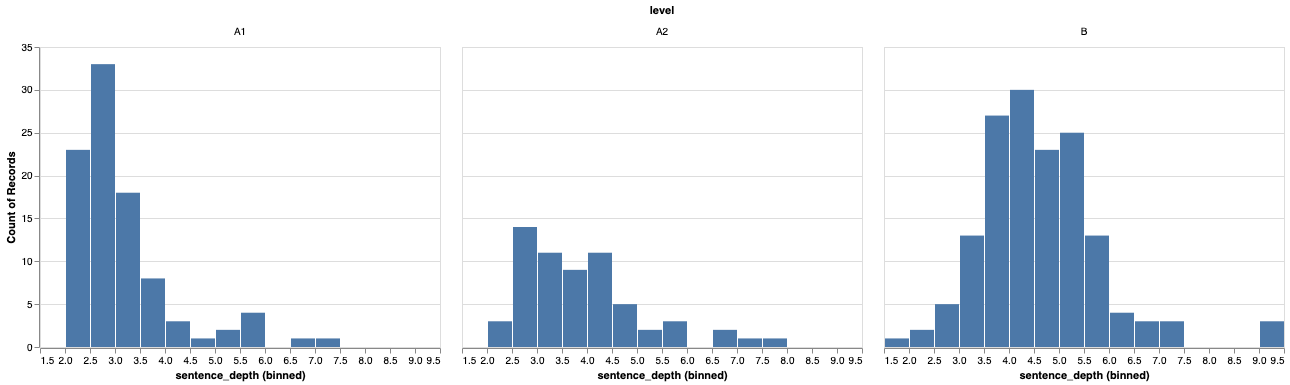

In [13]:
level_depth_depparse_df = pd.DataFrame(level_depth_depparse)
alt.Chart(level_depth_depparse_df).mark_bar().encode(x = alt.X('sentence_depth', bin = alt.Bin(maxbins = 30)), y = 'count()').facet('level')

### Density Distribution Plot: Okayed by Jungyuel 

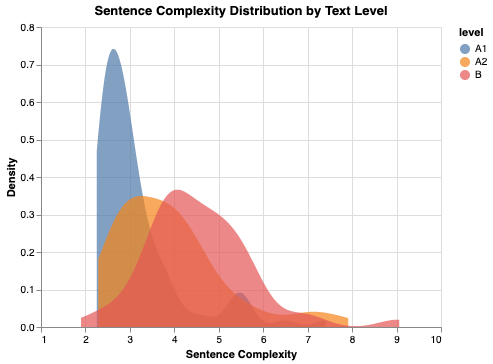

In [14]:
alt.Chart(level_depth_depparse_df, title = 'Sentence Complexity Distribution by Text Level').transform_density('sentence_depth', groupby=['level'], as_=['sentence_depth', 'density']
                                                    ).mark_area(interpolate='monotone', opacity = 0.7
                                                    ).encode(x = alt.X('sentence_depth', title = 'Sentence Complexity'), y = alt.Y('density:Q', title = 'Density'), color = 'level')

### Another plot suggested to Jungyuel - Let's not use this. 

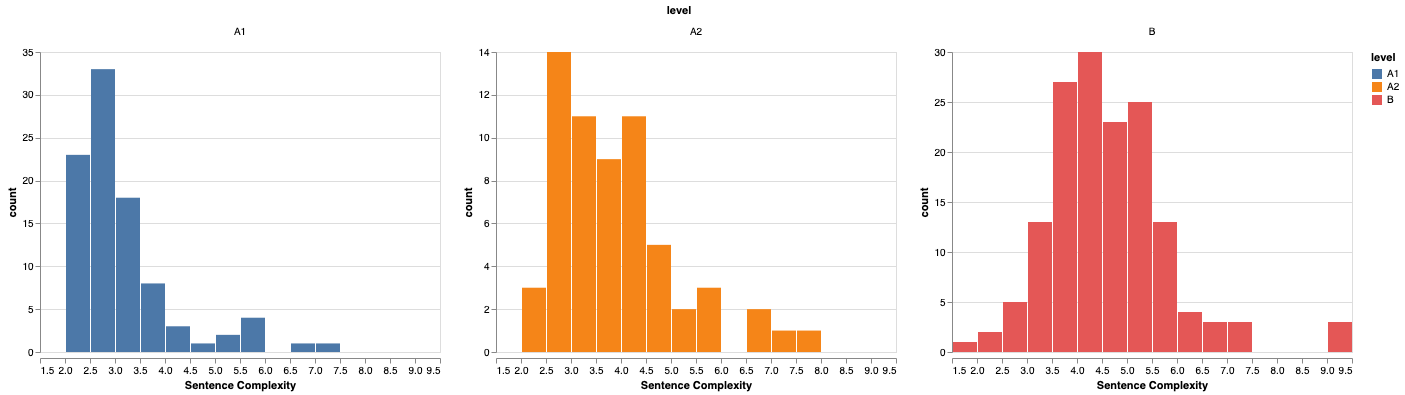

In [15]:
alt.Chart(level_depth_depparse_df, title = 'Sentence Complexity Distribution by Text Level').mark_bar(
            ).encode(x = alt.X('sentence_depth', title = 'Sentence Complexity', bin = alt.Bin(maxbins = 30)), y = alt.Y('count()', title = 'count'), color = 'level').facet('level').resolve_scale(y='independent')